# Flares in LSST Fields

*A few summary figures*

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import flare_prob
import LSSToy

matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

In [2]:
# This flag controls whether to use the LSSToy simulation (False),
# or the reduced files from OpSim that Ruth provided (True)
use_opsim = True

dmag_limit = (-0.01, -0.05, -0.1) # flare detection threshold(s), in mag
# dmag_limit = -0.1

In [3]:
# let's read in the Trilegal field, and see the columns

# l=45, b=-40, fov=3.5
# file = 'trilegal_models/output164538496014.dat'

# l=45, b=-20, fov=3.5
file = 'trilegal_models/output261611164854.dat'
df = pd.read_table(file, sep=r"\s*", engine='python')
# df

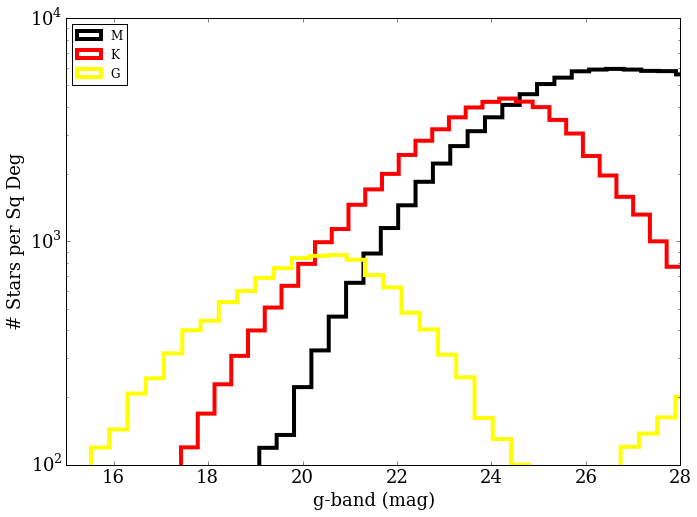

In [4]:
# make a histogram of # of stars versus Apparent Mag in each temperature bin (3k to 7k)
Teff_bins = np.log10(np.arange(3000,8000,1000))

fov = 3.5 # sq deg (size of Trilegal field)
LSSTfov = 9.6

# clrs = ['crimson','darkorange','cornflowerblue']
clrs = ['black', 'red', 'yellow']
lbl = ['M', 'K', 'G']

plt.figure(figsize=(11,8))
for k in range(len(Teff_bins)-2):
    x = np.where((df['logg'] >= 4) & (df['logTe'] >= Teff_bins[k]) & (df['logTe'] < Teff_bins[k+1]))
    _ = plt.hist(df['g'].values[x], bins=50, color=clrs[k], histtype='step', lw=4, 
                 weights=np.ones(len(x[0]))/3.5, label = lbl[k])
plt.yscale('log')
plt.xlim(15,28)
plt.ylim(1e2,1e4)
plt.xlabel('g-band (mag)')
plt.ylabel('# Stars per Sq Deg')
plt.legend(fontsize=12, loc=2)

plt.savefig('b-20_GKM.pdf', dpi=300, rasterized=True, bbox_inches='tight', pad_inches=0.5)

## Generate flares at different rates, test recovery % for LSST cadence

Only varying the $\alpha$ parameter, which controls the intercept in the Flare Frequency Distribution powerlaw. Thus we always use a fixed slope for the energy distribution, $\beta$.

In [5]:
dur = 1.0 # duration to simulate (in years)
ffd_beta = -2.0 # ffd slope
ffd_min = 0

s_time1, s_flux1 = flare_prob.SuperLC(dur=dur, repeat=10./dur, mag=True, ffd_alpha=1, ffd_beta=ffd_beta, ffd_min=ffd_min)
s_time2, s_flux2 = flare_prob.SuperLC(dur=dur, repeat=10./dur, mag=True, ffd_alpha=0, ffd_beta=ffd_beta, ffd_min=ffd_min)
s_time3, s_flux3 = flare_prob.SuperLC(dur=dur, repeat=10./dur, mag=True, ffd_alpha=-1, ffd_beta=ffd_beta, ffd_min=ffd_min)

In [6]:
s_time4, s_flux4 = flare_prob.SuperLC(dur=dur, repeat=10./dur, mag=True, ffd_alpha=-2, ffd_beta=ffd_beta, ffd_min=ffd_min)
s_time5, s_flux5 = flare_prob.SuperLC(dur=dur, repeat=10./dur, mag=True, ffd_alpha=-3, ffd_beta=ffd_beta, ffd_min=ffd_min)
s_time6, s_flux6 = flare_prob.SuperLC(dur=dur, repeat=10./dur, mag=True, ffd_alpha=-4, ffd_beta=ffd_beta, ffd_min=ffd_min)

$\alpha$ = [1, 0, -1, -2, -3, -4]

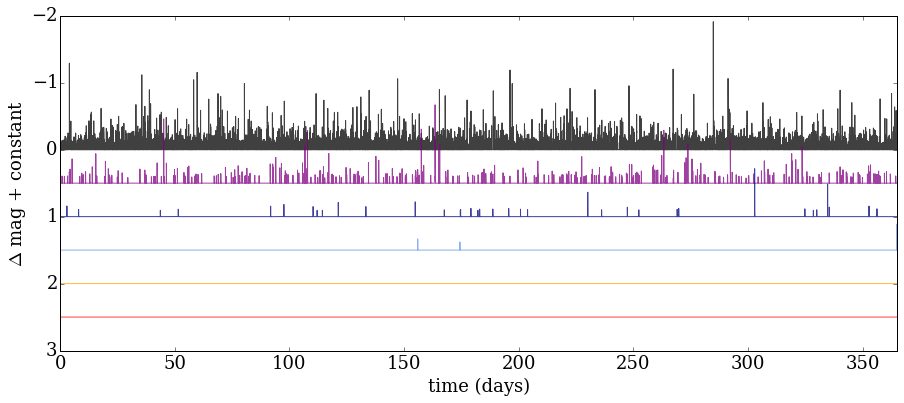

In [7]:
plt.figure(figsize=(15,6))
plt.plot(s_time1, s_flux1, alpha=0.75, c='black')
plt.plot(s_time2, s_flux2+0.5, alpha=0.75, c='purple')
plt.plot(s_time3, s_flux3+1, alpha=0.75, c='navy')
plt.plot(s_time4, s_flux4+1.5, alpha=0.75, c='cornflowerblue')
plt.plot(s_time5, s_flux5+2, alpha=0.75, c='orange')
plt.plot(s_time6, s_flux6+2.5, alpha=0.75, c='red')
plt.xlim(0, dur*365.)
plt.ylim((3,-2))
plt.xlabel('time (days)')
plt.ylabel('$\Delta$ mag + constant')

# plt.savefig('lightcurves.png', dpi=300, rasterized=True, bbox_inches='tight', pad_inches=0.5)

## Now sample from the actual field!

In [8]:
Age_bins = np.log10([1e5, 0.25e9, 1.5e9, 15e9]) # edges of age bins

alpha_matrix = np.array([[1, -1, -2],   # 3k-4k
                         [0, -2, -4],  # 4k-5k
                         [-1, -4, -6], # 5k-6k
                         [-4, -9, -9]]) # 6k-7k

Nstars = 50000 # how many stars to randomly sample from logg>=4, Teff<7k

/Users/davenpj3/anaconda/envs/python2/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


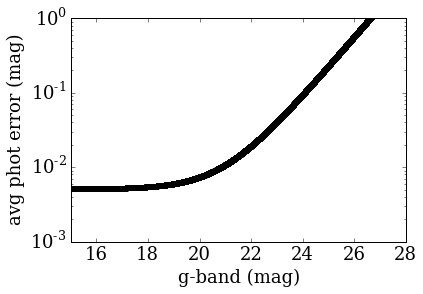

In [9]:
# find the stars to draw from
okstars = np.where((df['logg'] >= 4) & (df['logTe'] <= np.log10(7000.0)) & (df['logTe'] >= np.log10(3000.0)))

# pick random indexes to use from good stars
rr = np.array(np.floor((np.random.random(size=Nstars) * float(len(okstars[0])))), dtype=np.int)

teff = df['logTe'].values[okstars[0][rr]]
age = df['logAge'].values[okstars[0][rr]]

gmag = df['g'].values[okstars[0][rr]] # apparant g-band magnitude
gerr = LSSToy.photerror(gmag)

plt.scatter(gmag, gerr, color='k')
plt.ylim(1e-3,1)
plt.yscale('log')
plt.xlim(15,28)
plt.xlabel('g-band (mag)')
plt.ylabel('avg phot error (mag)')

# plt.savefig('error_profile.pdf', dpi=300, rasterized=True, bbox_inches='tight', pad_inches=0.5)

In [10]:
# # Count how many flares are returned for each star
# Nflares = np.zeros(Nstars)

# Nflares1 = np.zeros(Nstars)
# Nflares5 = np.zeros(Nstars)


# # loop over all Nstars and measure flare returns!
# for k in range(Nstars):
#     # which are bin?
#     wage = min(np.where((Age_bins >= np.float(age[k])))[0]) - 1

#     # which temp bin?
#     wteff = min(np.where((Teff_bins >= np.float(teff[k])))[0]) - 1

#     # pick the activity level based on that
#     aa = alpha_matrix[wteff, wage]

#     # pick the correct flare light curve
#     if aa == 1:
#         tt, ff = s_time1, s_flux1
#     if aa == 0:
#         tt, ff = s_time2, s_flux2
#     if aa == -1:
#         tt, ff = s_time3, s_flux3
#     if aa == -2:
#         tt, ff = s_time4, s_flux4
#     if aa == -4:
#         tt, ff = s_time5, s_flux5
#     if aa == -6:
#         tt, ff = s_time6, s_flux6
#     if aa < -6: # no flares
#         tt, ff = s_time6, s_flux6 * 0.0
    
#     # down-sample to LSST cadence
#     if use_opsim is True:
#         t, f, err = opsim_downsample(tt, ff, -20)
#     else:            
#         t,f = LSSToy.downsample(tt, ff)
    
#     # find where LSST data >= Flare threshold (+ phot errors!)
#     ok = np.where((f <= (dmag_limit - gerr[k])))
#     Nflares[k] = len(ok[0])
    
#     ok1 = np.where((f <= (dmag_limit - gerr[k])) & (t <= 365.*1.))
#     ok5 = np.where((f <= (dmag_limit - gerr[k])) & (t <= 365.*5.))

#     Nflares1[k] = len(ok1[0])
#     Nflares5[k] = len(ok5[0])

In [11]:
# plt.figure(figsize=(9,7))
# plt.scatter(10.**teff, Nflares + 0.1, s=40)
# plt.yscale('log')
# plt.xlabel('$T_{eff}$')
# plt.ylabel('# Flares Recovered in 10 years')
# plt.vlines(10.**Teff_bins,1,100, alpha=0.5, color='orange', lw=5)
# plt.ylim(1,100)
# plt.xlim(2800, 6500)

In [12]:
# plt.figure(figsize=(9,7))
# _ = plt.hist(gmag, weights=Nflares, bins=25, histtype='step')

# gbins = np.arange(16, 28, 0.5)
# _ = plt.hist(gmag, weights=Nflares, bins=gbins, histtype='step')

# plt.xlim(15,28)
# plt.xlabel('g-band (mag)')
# plt.ylabel('# flares recovered')
# plt.title('all stars in field, over all LSST exposures')

In [13]:
# '''
#  NOW MAKE SAME PLOT AS ABOVE BUT:
 
#  - 1, 5, 10 yr yields
#  - follow style of combined version later
 
# '''

# plt.figure(figsize=(9,7))
# plt.hist(gmag, weights=Nflares * (float(len(df)) / float(Nstars)) / fov + 1e-5, 
#             bins=25, histtype='step', color='orange', lw=4, label='10 yr')
# plt.hist(gmag, weights=Nflares5 * (float(len(df)) / float(Nstars)) / fov + 1e-5, 
#             bins=25, histtype='step', color='red', lw=4, label='5 yr')
# plt.hist(gmag, weights=Nflares1 * (float(len(df)) / float(Nstars)) / fov + 1e-5, 
#             bins=25, histtype='step', color='blue', lw=4, label='1 yr')

# plt.xlim(15,28)
# # plt.yscale('log')
# plt.legend(loc=0, fontsize=12)
# plt.xlabel('g-band (mag)')
# plt.ylabel('# Flares per Sq Deg')

# plt.savefig('b-20_flareyield.pdf', dpi=300, rasterized=True, bbox_inches='tight', pad_inches=0.5)

In [14]:
# gbins = np.arange(16, 28, 0.5)

# # all_stars, _ = np.histogram(gmag, bins=gbins)
# fl_stars, _ = np.histogram(gmag, bins=gbins, weights=Nflares)

# plt.figure(figsize=(9,7))
# plt.plot((gbins[1:] + gbins[0:-1])/2., fl_stars * (len(df) / Nstars) / fov)
# plt.xlabel('g-band (mag)')
# plt.ylabel('# Flares per Sq Deg')

# Repeat Study for all Trilegal fields (as a function of $b$)

>
> Running output574523944248.dat, b=-10.0
> looping...
Max distance for a 0.01mag flare star: 9549.92586021
Max distance for a 0.05mag flare star: 9549.92586021
Max distance for a 0.1mag flare star: 9549.92586021
Fraction of 0.1mag flares from M dwarfs: 0.971074380165

>
> Running output261611164854.dat, b=-20.0
> looping...
Max distance for a 0.01mag flare star: 6309.5734448
Max distance for a 0.05mag flare star: 6309.5734448
Max distance for a 0.1mag flare star: 6025.59586074
Fraction of 0.1mag flares from M dwarfs: 0.976076555024

>
> Running output164538496014.dat, b=-40.0
> looping...
Max distance for a 0.01mag flare star: 5754.39937337
Max distance for a 0.05mag flare star: 5754.39937337
Max distance for a 0.1mag flare star: 5754.39937337
Fraction of 0.1mag flares from M dwarfs: 1.0

>
> Running output208849261588.dat, b=-60.0
> looping...
Max distance for a 0.01mag flare star: 4168.6938347
Max distance for a 0.05mag flare star: 4168.6938347
Max distance for a 0.1mag flare star

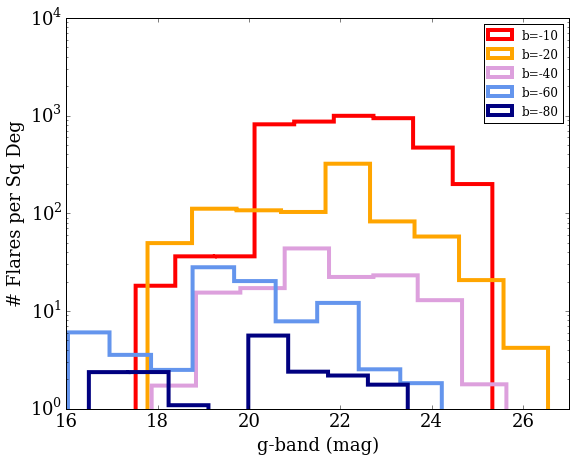

In [42]:
files, galb = np.loadtxt('trilegal_models/index.txt', comments='#', unpack=True, 
                         usecols=(0,2), dtype='str', delimiter=',')

galb = np.array(galb, dtype='float') # the galactic latitudes
totflares = np.zeros((len(galb), len(dmag_limit)))
totstars = np.zeros(len(galb))
Nepochs = np.zeros(len(galb)) # count actual number of visits used

# arrays to compute the number of flares per sq deg as function of g-band mag
gbins = np.arange(15.25, 29, 0.5)
fl_stars = np.zeros((len(gbins)-1, len(files)), dtype='float')

clrs = ['red', 'orange', 'plum', 'cornflowerblue', 'navy']
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(1,1,1)

Nflares1 = np.zeros(Nstars)
Nflares5 = np.zeros(Nstars)
Nflares10 = np.zeros(Nstars)

for j in range(len(files)):
    print('>')
    file = 'trilegal_models/' + files[j]
    df = pd.read_table(file, sep=r"\s*", engine='python')
    
    # ingest code from LSSToy to speed things up
    #+
    Ldir = 'cadence_files/'
    ufile = 'l45b' + str(int(galb[j])) + '.0_u_cadence.txt'
    gfile = 'l45b' + str(int(galb[j])) + '.0_g_cadence.txt'
    tu, mu = np.loadtxt(Ldir + ufile, dtype='float', unpack=True)
    tg, mg = np.loadtxt(Ldir + gfile, dtype='float', unpack=True)

    u2g = 2.0  # ratio of u-band to g-band flare flux (ad hoc)
    sclu = np.ones_like(tu) * u2g
    sclg = np.ones_like(tg)

    tout = np.concatenate((tu, tg))
    m5 = np.concatenate((mu, mg))
    scl = np.concatenate((sclu, sclg))

    ss = np.argsort(tout)
    tout = tout[ss]
    m5 = m5[ss]
    scl = scl[ss]
    #-
    
    print('> Running ' + files[j] + ', b=' + str(galb[j]))
    
    # find the stars to draw from
    okstars = np.where((df['logg'] >= 4) & (df['logTe'] <= np.log10(7000.0)) & (df['logTe'] >= np.log10(3000.0)))
    # pick random indexes to use from good stars
    rr = np.array(np.floor((np.random.random(size=Nstars) * float(len(okstars[0])))), dtype=np.int)
    teff = df['logTe'].values[okstars[0][rr]]
    age = df['logAge'].values[okstars[0][rr]]
    dist = 10.**(df['m-M0'].values[okstars[0][rr]]/5. + 1.)
    gmag = df['g'].values[okstars[0][rr]] # apparant g-band magnitude
    gerr = LSSToy.photerror(gmag)

    if (galb[j] == -20):
        gmag20 = gmag
        
    # Count how many flares are returned for each star, for all dmag_limit thresholds
    Nflares = np.zeros((Nstars, len(dmag_limit)))

    print('> looping...')
    # loop over all Nstars and measure flare returns!
    for k in range(Nstars):
        # which are bin?
        wage = min(np.where((Age_bins >= np.float(age[k])))[0]) - 1

        # which temp bin?
        wteff = min(np.where((Teff_bins >= np.float(teff[k])))[0]) - 1

        # pick the activity level based on that
        aa = alpha_matrix[wteff, wage]

        # pick the correct flare light curve
        if aa == 1:
            tt, ff = s_time1, s_flux1
        if aa == 0:
            tt, ff = s_time2, s_flux2
        if aa == -1:
            tt, ff = s_time3, s_flux3
        if aa == -2:
            tt, ff = s_time4, s_flux4
        if aa == -4:
            tt, ff = s_time5, s_flux5
        if aa == -6:
            tt, ff = s_time6, s_flux6
        if aa < -6: # no flares
            tt, ff = s_time6, s_flux6 * 0.0

        # down-sample to LSST cadence
        if use_opsim is True:
            t = np.random.choice(tt, len(tout))
            f = np.interp(t, tt, ff)
            gerrk = LSSToy.photerror(gmag[k] + f, m5=m5)
#             t, f, gerrk, scl = LSSToy.opsim_cadence(tt, ff, gmag[k], galb[j], random=True)

        else:
            gerrk = gerr[k]
            scl = 1.
            t,f = LSSToy.downsample(tt, ff)

        # find where LSST data >= Flare threshold (+ phot errors!)
        for i in range(len(dmag_limit)):
            ok = np.where((f*scl <= (dmag_limit[i] - gerrk)))
            Nflares[k,i] = len(ok[0])
        
        if (galb[j] == -20):
            if len(ok[0]) > 0:
                Nflares1[k] = sum(t[ok] <= 365.)
                Nflares5[k] = sum(t[ok] <= 365.*5.)
                Nflares10[k] = len(ok[0])
    
    print('Max distance for a 0.01mag flare star: ' + str(max(dist[np.where((Nflares[:,0] > 0))])))
    print('Max distance for a 0.05mag flare star: ' + str(max(dist[np.where((Nflares[:,1] > 0))])))
    print('Max distance for a 0.1mag flare star: ' + str(max(dist[np.where((Nflares[:,-1] > 0))])))

    print('Fraction of 0.1mag flares from M dwarfs: ' + str(sum(Nflares[:,-1][np.where((10.**teff <= 4000))]) / sum(Nflares[:,-1])))
    print('')
    
    totflares[j,:] = np.sum(Nflares, axis=0)
    totstars[j] = len(df)
    Nepochs[j] = len(t) # the number of visits will always be the same in each field
        
    
    fl_tmp, _ = np.histogram(gmag, bins=gbins, weights=Nflares[:,-1])
    fl_stars[:,j] = fl_tmp
    
    #ax.plot(gbins[1:], fl_stars[:,k] * (float(totstars[k]) / float(Nstars)) / fov + 1e-5, 
    #        color=clrs[k], lw=4, ls='-', label='l='+str(int(galb[k])))
    ax.hist(gmag, weights=Nflares[:,-1] * (float(len(df)) / float(Nstars)) / fov + 1e-5, 
            bins=25, histtype='step', color=clrs[j], lw=4, label='b='+str(int(galb[j])))
    
plt.xlim(16,27)
plt.ylim(1e0, 1e4)
plt.yscale('log')
plt.xlabel('g-band (mag)')
plt.ylabel('# Flares per Sq Deg')

ax.legend(loc=0, fontsize=12)
plt.savefig('flare_depth_better.pdf', dpi=300, rasterized=True, bbox_inches='tight', pad_inches=0.5)

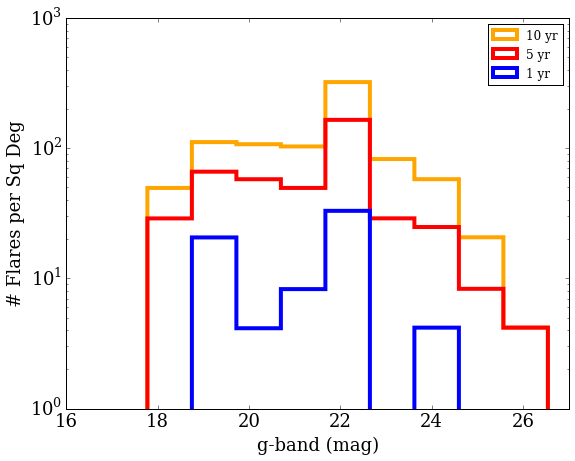

In [43]:

plt.figure(figsize=(9,7))
plt.hist(gmag20, weights=Nflares10 * float(totstars[1]) / float(Nstars) / fov + 1e-5, bins=25, 
         histtype='step', color='orange', lw=4, label='10 yr')
plt.hist(gmag20, weights=Nflares5 * float(totstars[1]) / float(Nstars) / fov + 1e-5, 
            bins=25, histtype='step', color='red', lw=4, label='5 yr')
plt.hist(gmag20, weights=Nflares1 * float(totstars[1]) / float(Nstars) / fov + 1e-5, 
            bins=25, histtype='step', color='blue', lw=4, label='1 yr')

plt.xlim(16,27)
plt.ylim(1,1e3)
plt.yscale('log')
plt.legend(loc=0, fontsize=12)
plt.xlabel('g-band (mag)')
plt.ylabel('# Flares per Sq Deg')

plt.savefig('b-20_flareyield.pdf', dpi=300, rasterized=True, bbox_inches='tight', pad_inches=0.5)

In [44]:
# clrs = ['red', 'orange', 'plum', 'cornflowerblue', 'navy']
# fig = plt.figure(figsize=(9,7))
# ax = fig.add_subplot(1,1,1)

# for k in range(0,len(files),1):
#     ax.plot(gbins[1:], fl_stars[:,k] * (float(totstars[k]) / float(Nstars)) / fov + 1e-5, 
#             color=clrs[k], lw=4, ls='-', label='b='+str(int(galb[k])))

# plt.xlim(16,27)
# plt.ylim(1e0, 1e4)
# plt.yscale('log')
# plt.xlabel('g-band (mag)')
# plt.ylabel('# Flares per Sq Deg')

# ax.legend(loc=0, fontsize=12)
# plt.savefig('flare_depth.pdf', dpi=300, rasterized=True, bbox_inches='tight', pad_inches=0.5)

In [45]:
# plt.figure(figsize=(9,7))
# plt.scatter(galb, totflares / Nstars / 10, s=50)
# plt.xlabel('b, galactic latitude (deg) @ l=45')
# plt.ylabel('Total Flares per Star per year')

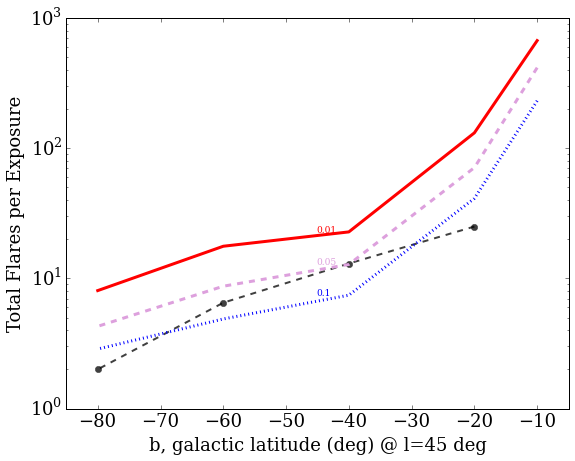

In [46]:
lss = ['solid', 'dashed', 'dotted']
colors = ['red', 'plum', 'blue']
plt.figure(figsize=(9,7))

# Result from Hilton (2011) simulation at l=90
plt.plot([-20, -40, -60, -80], [25, 13, 6.5, 2],'--o', color='k', lw=2, alpha=0.75)

for k in range(0, len(dmag_limit)):
    plt.plot(galb, totflares[:,k] / Nepochs * ( totstars / Nstars) * (LSSTfov / fov),
             ls = lss[k], color=colors[k], lw=3)
    
    plt.text(-45, totflares[2,k] / Nepochs[2] * ( totstars[2] / Nstars) * (LSSTfov / fov), 
             '' + str(np.abs(dmag_limit[k])), fontsize=9, color=colors[k])

plt.xlabel('b, galactic latitude (deg) @ l=45 deg')
plt.ylabel('Total Flares per Exposure')
plt.yscale('log')

plt.xlim(-85,-5)

plt.savefig('flare_b.pdf', dpi=300, rasterized=True, bbox_inches='tight', pad_inches=0.5)

In [47]:
# plt.figure(figsize=(9,7))
# plt.scatter(galb, totflares / Nstars / 900 * totstars / fov, s=60, c='k')
# plt.xlabel('b, galactic latitude (deg) @ l=45 deg')
# plt.ylabel('Total Flares per Sq Deg per Exposure')
# plt.yscale('log')
# plt.savefig('flare_b_rate.pdf', dpi=300, rasterized=True, bbox_inches='tight', pad_inches=0.5)

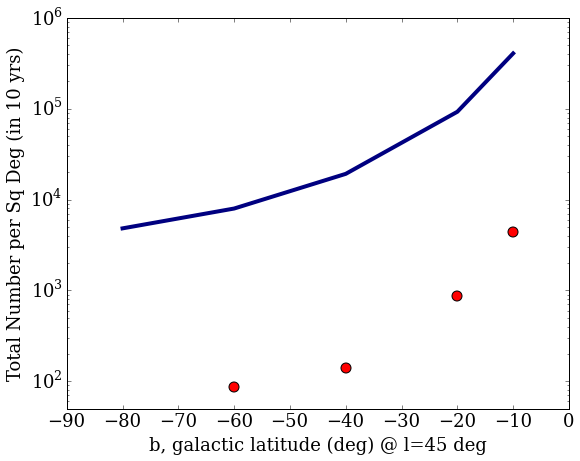

In [48]:
# rot_num = [5.42e5, 1.19e5, 2.45e4, 1.01e4, 6.17e3]
# rot_num = [3.28e5, 6.97e4, 1.43e4, 5.86e3, 3.63e3]
rot_num = [4.07e5, 9.27e4, 1.92e4, 7.97e3, 4.82e3]

plt.figure(figsize=(9,7))

# for k in range(0, len(dmag_limit)):
k=-1
use_g = [0,1,2,3,4]
plt.scatter(galb[use_g], totflares[use_g,k] / Nstars * totstars[use_g] / fov, s=100, c='r')

plt.plot(galb[use_g], np.array(rot_num)[use_g], lw=4, color='navy')
plt.xlabel('b, galactic latitude (deg) @ l=45 deg')
# plt.ylabel('Total Flares per Sq Deg (in 10 yrs)')
plt.ylabel('Total Number per Sq Deg (in 10 yrs)')
plt.yscale('log')
plt.ylim(0.5e2,1e6)
plt.savefig('flare_rate_10yr.pdf', dpi=300, rasterized=True, bbox_inches='tight', pad_inches=0.5)

In [49]:
# # # make histogram of GKM stars in each field (per sq deg)

# clrs = ['red', 'orange', 'plum', 'cornflowerblue', 'navy']

# plt.figure(figsize=(9,7))

# for j in range(len(files)-1):
#     file = 'trilegal_models/' + files[j]
#     df = pd.read_table(file, sep=r"\s*", engine='python')

#     x = np.where((df['logg'] >= 4) & (df['logTe'] >= np.log10(3000)) & (df['logTe'] < np.log10(6000)))
#     _ = plt.hist(df['g'].values[x], bins=50, color=clrs[j], histtype='step', lw=4, 
#                  weights=np.ones(len(x[0]))/3.5, label='b='+str(int(galb[j])))
    
#     print(files[j] + ', # stars per sq deg = ' + str(len(x[0])/fov))
    
# plt.yscale('log')
# plt.xlim(15,28)
# plt.ylim(1e1,1e5)
# plt.xlabel('g-band (mag)')
# plt.ylabel('# Stars per Sq Deg')
# plt.legend(fontsize=12, loc=2)

# plt.savefig('all_GKM.pdf', dpi=300, rasterized=True, bbox_inches='tight', pad_inches=0.5)